In [1]:
import matplotlib.pylab as pl
%matplotlib inline
import numpy as np
import pickle
import random
import time

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


### Problem 2 A Normalize Data
    Please refer to normalize_data.py.

In [2]:
X, Y = pickle.load(open('normalized_data', 'rb'))
N, D = X.shape
X_mean, X_std, Y_mean, Y_std = pickle.load(open('statistics', 'rb'))

### Problem 2 B Gradient Descent

In [3]:
def predict(W, bias, X):
    return np.dot(X, W) + bias
def forward(W, bias, X, Y):
    # calculate MSE and cache necessary intermediates for gradient calculation
    predictions = predict(W, bias, X)
    difference = predictions - Y
    loss = 0.5 * np.mean(difference ** 2, axis=0)
    cache = (difference,)
    return loss, cache
def backward(W, bias, X, Y, cache):
    # calculate gradients
    difference, = cache
    dW = np.mean(X * difference, axis=0).reshape(W.shape)
    dbias = np.mean(difference)
    return dW, dbias

In [4]:
def batches(data, batch_size, cyclic=False, shuffle=False):
    # generator that iterate through data
    n_batches = len(data) // batch_size
    i = 0
    if shuffle:
        indices = list(range(n_batches))
        random.shuffle(indices)
    else: indices = range(n_batches)
    while True:
        index = indices[i]
        yield data[index * batch_size : (index + 1) * batch_size]
        if cyclic: i = (i + 1) % n_batches
        else:
            if i + 1 == n_batches: return
            else: i += 1

In [5]:
def train(W, bias, X, Y, batch_size, lr, n_iterations, logging_interval=None):
    X_batches, Y_batches = batches(X, batch_size, cyclic=True), batches(Y, batch_size, cyclic=True)
    loss_history = []
    for iteration in range(n_iterations):
        X_batch, Y_batch = next(X_batches), next(Y_batches)
        loss, cache = forward(W, bias, X_batch, Y_batch)
        dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
        W -= lr * dW
        bias -= lr * dbias
        if logging_interval is not None and (iteration + 1) % logging_interval == 0:
            print('iteration %d loss %f' % (iteration + 1, loss))
        loss_history.append(loss)
    return loss_history

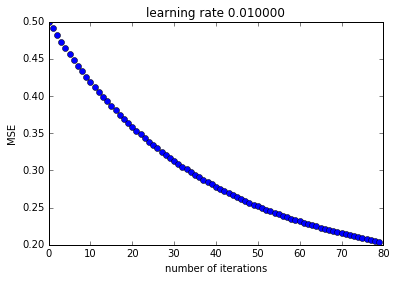

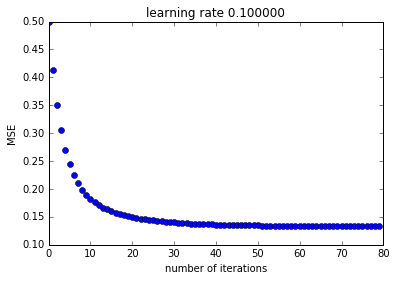

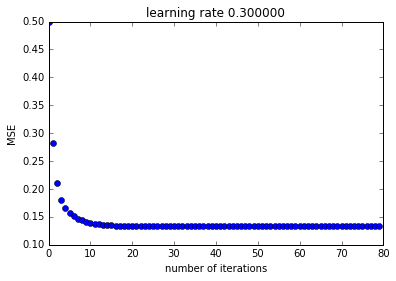

In [6]:
loss_histories = {}
batch_size = N
n_iterations = 80
for lr in (0.01, 0.1, 0.3):
    W = np.zeros((2, 1))
    bias = np.zeros(1)
    loss_history = train(W, bias, X, Y, N, lr, n_iterations, None)
    pl.figure()
    pl.plot(range(n_iterations), loss_history, 'bo')
    pl.title('learning rate %f' % lr)
    pl.xlabel('number of iterations')
    pl.ylabel('MSE')
    loss_histories['gradient descent lr=%3f' % lr] = loss_history

### Problem 2 C Predicting Price

In [7]:
test_data = np.array([[1650, 3]])
test_data = (test_data - X_mean) / X_std
float(predict(W, bias, test_data) * Y_std + Y_mean)

293081.61816276633

### Problem 2 D Stochastic Gradient Descent

In [8]:
# implement the training strategy detailed in Problem 2 D
loss_history = []
W = np.zeros((2, 1))
bias = np.zeros(1)
batch_size = 1
X_batches, Y_batches = batches(X, batch_size, cyclic=False), batches(Y, batch_size, cyclic=False)
for X_batch, Y_batch in zip(X_batches, Y_batches):
    loss, cache = forward(W, bias, X_batch, Y_batch)
    dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
    W -= lr * dW
    bias -= lr * dbias
    loss_history.append(loss)
print('epoch 1 loss %f' % loss)
for epoch in (2, 3):
    X_batches = batches(X, batch_size, cyclic=False, shuffle=True)
    Y_batches = batches(Y, batch_size, cyclic=False, shuffle=True)
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        loss, cache = forward(W, bias, X_batch, Y_batch)
        dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
        W -= lr * dW
        bias -= lr * dbias
        loss_history.append(loss)
    print('epoch %d loss %f' % (epoch, loss))
loss_histories['sgd lr=0.1'] = loss_history

epoch 1 loss 0.122226
epoch 2 loss 0.002282
epoch 3 loss 0.189250


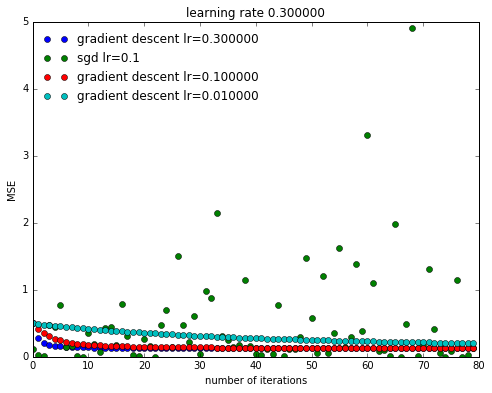

In [9]:
pl.figure(figsize=(8, 6))
for description, loss_history in loss_histories.items():
    pl.plot(range(80), loss_history[:80], 'o', label=description)
    pl.title('learning rate %f' % lr)
    pl.xlabel('number of iterations')
    pl.ylabel('MSE')
    pl.legend(framealpha=0, loc='best')

In [10]:
# test the result of stochastic gradient descent
test_data = np.array([[1650, 3]])
test_data = (test_data - X_mean) / X_std
float(predict(W, bias, test_data) * Y_std + Y_mean)

239288.6036196788